# Automatic number plate recognition (ANPR) with Yolov9 and EasyOCR

data: https://universe.roboflow.com/arvind-kumar-wjygd/anpr2-syxl7

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Sat Mar  1 06:38:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Clone and Install

**NOTE:** YOLOv9 is very new. At the moment, we recommend using a fork of the main repository. The `detect.py` script contains a bug that prevents inference. This bug is patched in the fork.

In [ ]:
!git clone https://github.com/SkalskiP/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 325, done.
remote: Total 325 (delta 0), reused 0 (delta 0), pack-reused 325 (from 1)
Receiving objects: 100% (325/325), 2.25 MiB | 28.40 MiB/s, done.
Resolving deltas: 100% (162/162), done.
/content/yolov9
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━

**NOTE:** Let's install the [`roboflow`](https://pypi.org/project/roboflow) package, which we will use to download our dataset from [Roboflow Universe](https://universe.roboflow.com/).

In [ ]:
!pip install -q roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 17.4 MB/s eta 0:00:00


## Download model weights

**NOTE:** In the YOLOv9 paper, versions `yolov9-s` and `yolov9-m` are also mentioned, but the weights for these models are not yet available in the YOLOv9 [repository](https://github.com/WongKinYiu/yolov9).

In [ ]:
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-c.pt
!wget -P {HOME}/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/gelan-e.pt

In [ ]:
!ls -la {HOME}/weights

total 402448
drwxr-xr-x 2 root root      4096 Mar  1 06:40 .
drwxr-xr-x 1 root root      4096 Mar  1 06:40 ..
-rw-r--r-- 1 root root  51508261 Feb 18  2024 gelan-c.pt
-rw-r--r-- 1 root root 117203713 Feb 18  2024 gelan-e.pt
-rw-r--r-- 1 root root 103153312 Feb 18  2024 yolov9-c.pt
-rw-r--r-- 1 root root 140217688 Feb 18  2024 yolov9-e.pt


## Authenticate and Download the Dataset

**NOTE:** The dataset must be saved inside the `{HOME}/yolov9` directory, otherwise, the training will not succeed.

In [ ]:
%cd {HOME}/yolov9

/content/yolov9


**NOTE:** In this tutorial, I will use the [football-players-detection](https://universe.roboflow.com/roboflow-jvuqo/football-players-detection-3zvbc) dataset. Feel free to replace it with your dataset in YOLO format or use another dataset available on [Roboflow Universe](https://universe.roboflow.com). Additionally, if you plan to deploy your model to Roboflow after training, make sure you are the owner of the dataset and that no model is associated with the version of the dataset you are going to training on.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="FMGJP8ns7o2H1dT8mWEQ")
project = rf.workspace("arvind-kumar-wjygd").project("anpr2-syxl7")
version = project.version(8)
dataset = version.download("yolov9")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to ANPR2-8 in yolov9:: 100%|██████████| 626/626 [00:00<00:00, 7305.20it/s]


## Train Custom Model

In [10]:
%cd {HOME}/yolov9

!python train.py \
--batch 16 --epochs 25 --img 640 --device 0 --min-items 0 --close-mosaic 15 \
--data {dataset.location}/data.yaml \
--weights {HOME}/weights/gelan-c.pt \
--cfg models/detect/gelan-c.yaml \
--hyp hyp.scratch-high.yaml

/content/yolov9
2025-03-01 06:54:29.304873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740812069.325974   11959 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740812069.332713   11959 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 06:54:29.354093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more inf

In [11]:
ls -l /content/yolov9/


total 288
drwxr-xr-x 5 root root  4096 Mar  1 06:48 ANPR2-8/
-rw-r--r-- 1 root root  6267 Mar  1 06:38 benchmarks.py
drwxr-xr-x 2 root root  4096 Mar  1 06:38 classify/
drwxr-xr-x 3 root root  4096 Mar  1 06:38 data/
-rw-r--r-- 1 root root 12310 Mar  1 06:38 detect.py
-rw-r--r-- 1 root root 28804 Mar  1 06:38 export.py
drwxr-xr-x 2 root root  4096 Mar  1 06:38 figure/
-rw-r--r-- 1 root root  4655 Mar  1 06:38 hubconf.py
drwxr-xr-x 7 root root  4096 Mar  1 06:43 models/
drwxr-xr-x 2 root root  4096 Mar  1 06:38 panoptic/
drwxr-xr-x 2 root root  4096 Mar  1 06:43 __pycache__/
-rw-r--r-- 1 root root  6480 Mar  1 06:38 README.md
-rw-r--r-- 1 root root  1073 Mar  1 06:38 requirements.txt
drwxr-xr-x 3 root root  4096 Mar  1 06:44 runs/
drwxr-xr-x 2 root root  4096 Mar  1 06:38 scripts/
drwxr-xr-x 2 root root  4096 Mar  1 06:38 segment/
-rw-r--r-- 1 root root 34312 Mar  1 06:38 train_dual.py
-rw-r--r-- 1 root root 33796 Mar  1 06:38 train.py
-rw-r--r-- 1 root root 33829 Mar  1 06:38 train_tri

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Examine Training Results

**NOTE:** By default, the results of each subsequent training sessions are saved in `{HOME}/yolov9/runs/train/`, in directories named `exp`, `exp2`, `exp3`, ... You can override this behavior by using the `--name` parameter.

In [12]:
!ls {HOME}/yolov9/runs/train/exp2/

confusion_matrix.png				     opt.yaml	   train_batch0.jpg
events.out.tfevents.1740812102.9e9019aa7698.11959.0  P_curve.png   train_batch1.jpg
F1_curve.png					     PR_curve.png  train_batch2.jpg
hyp.yaml					     R_curve.png   val_batch0_labels.jpg
labels_correlogram.jpg				     results.csv   val_batch0_pred.jpg
labels.jpg					     results.png   weights


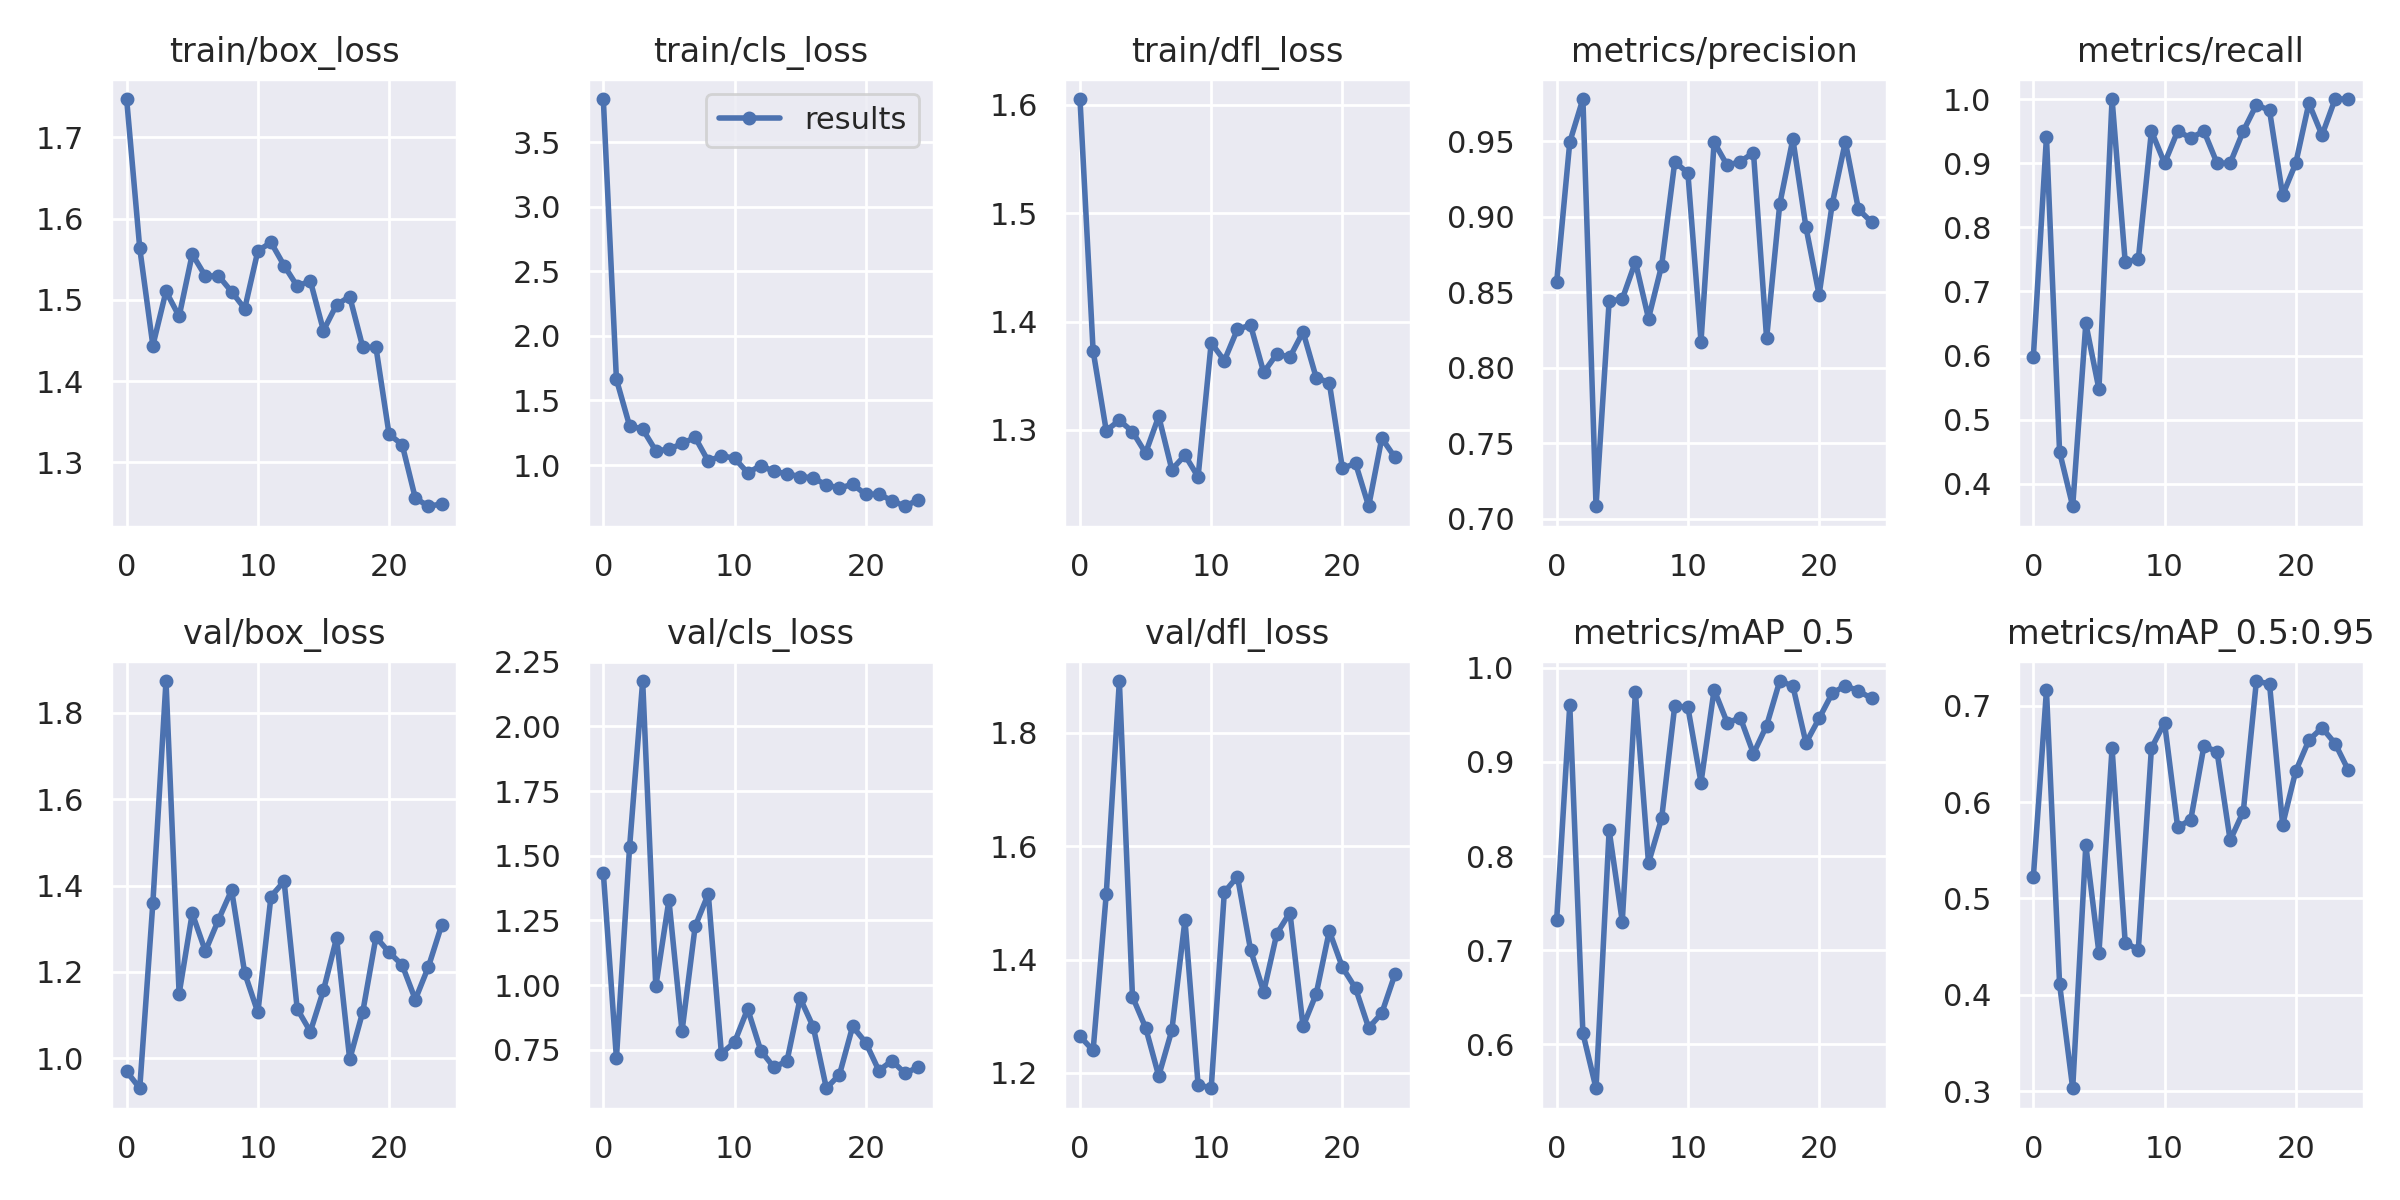

In [13]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp2/results.png", width=1000)

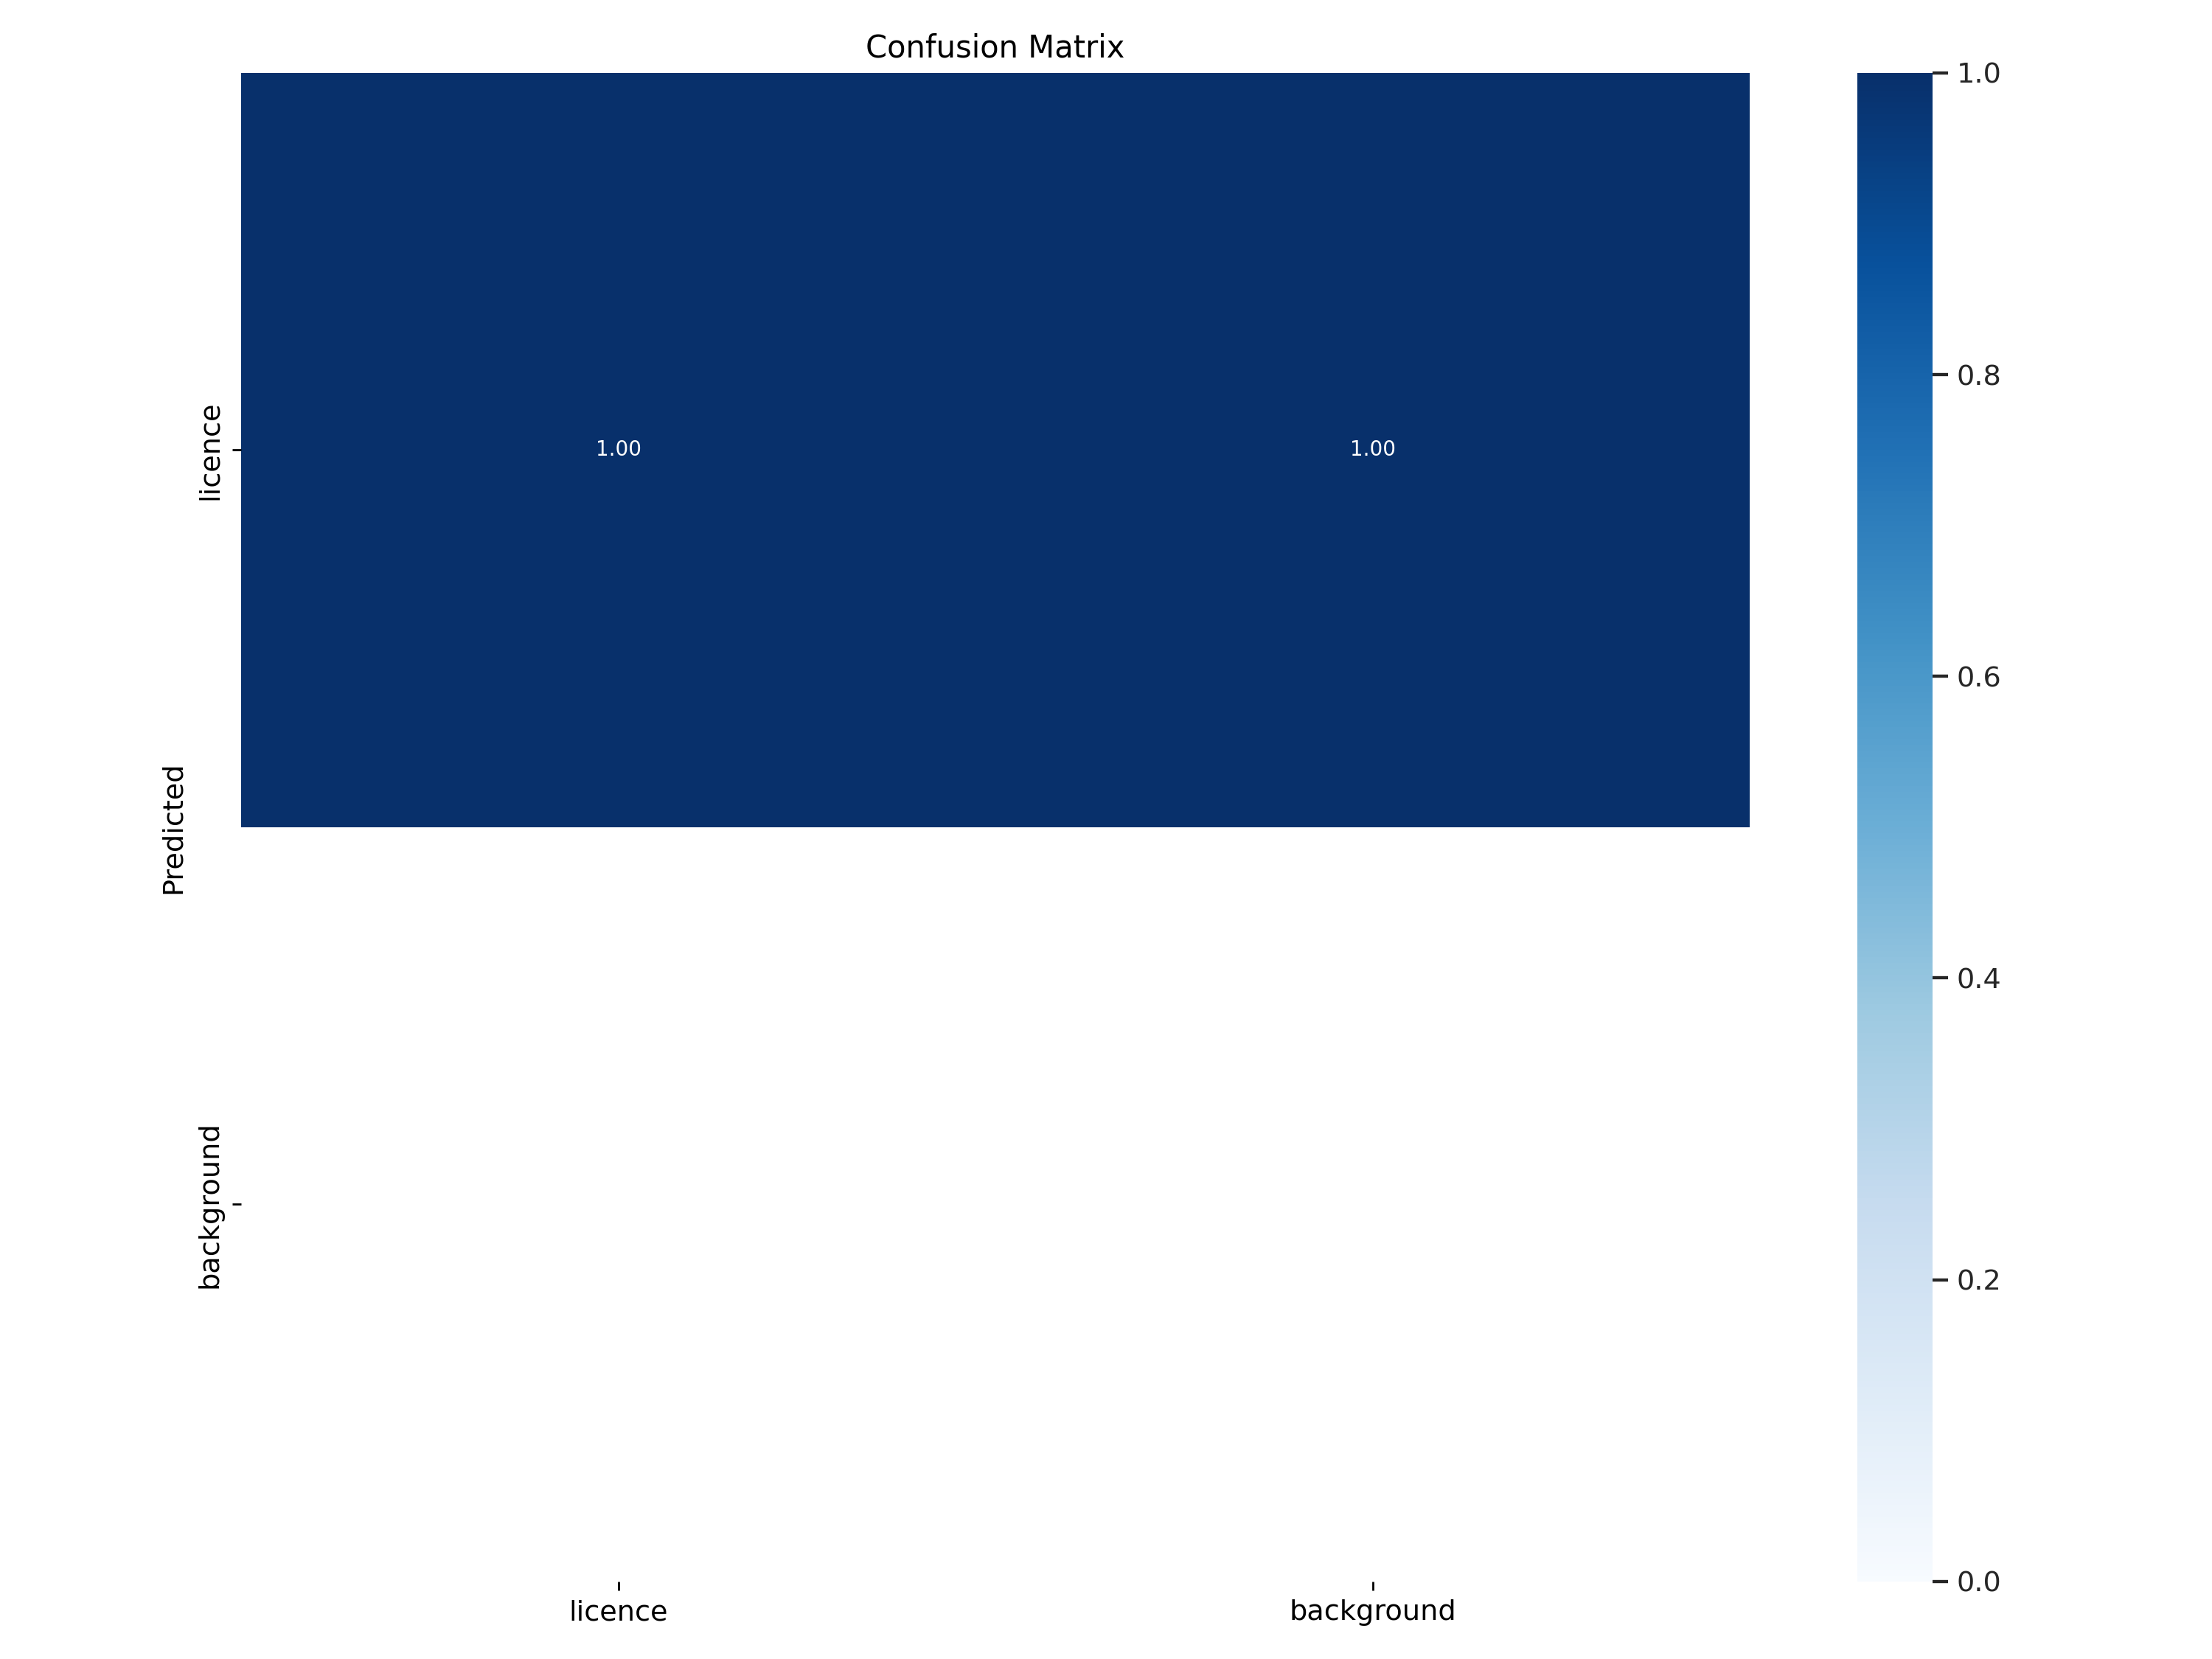

In [14]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp2/confusion_matrix.png", width=1000)

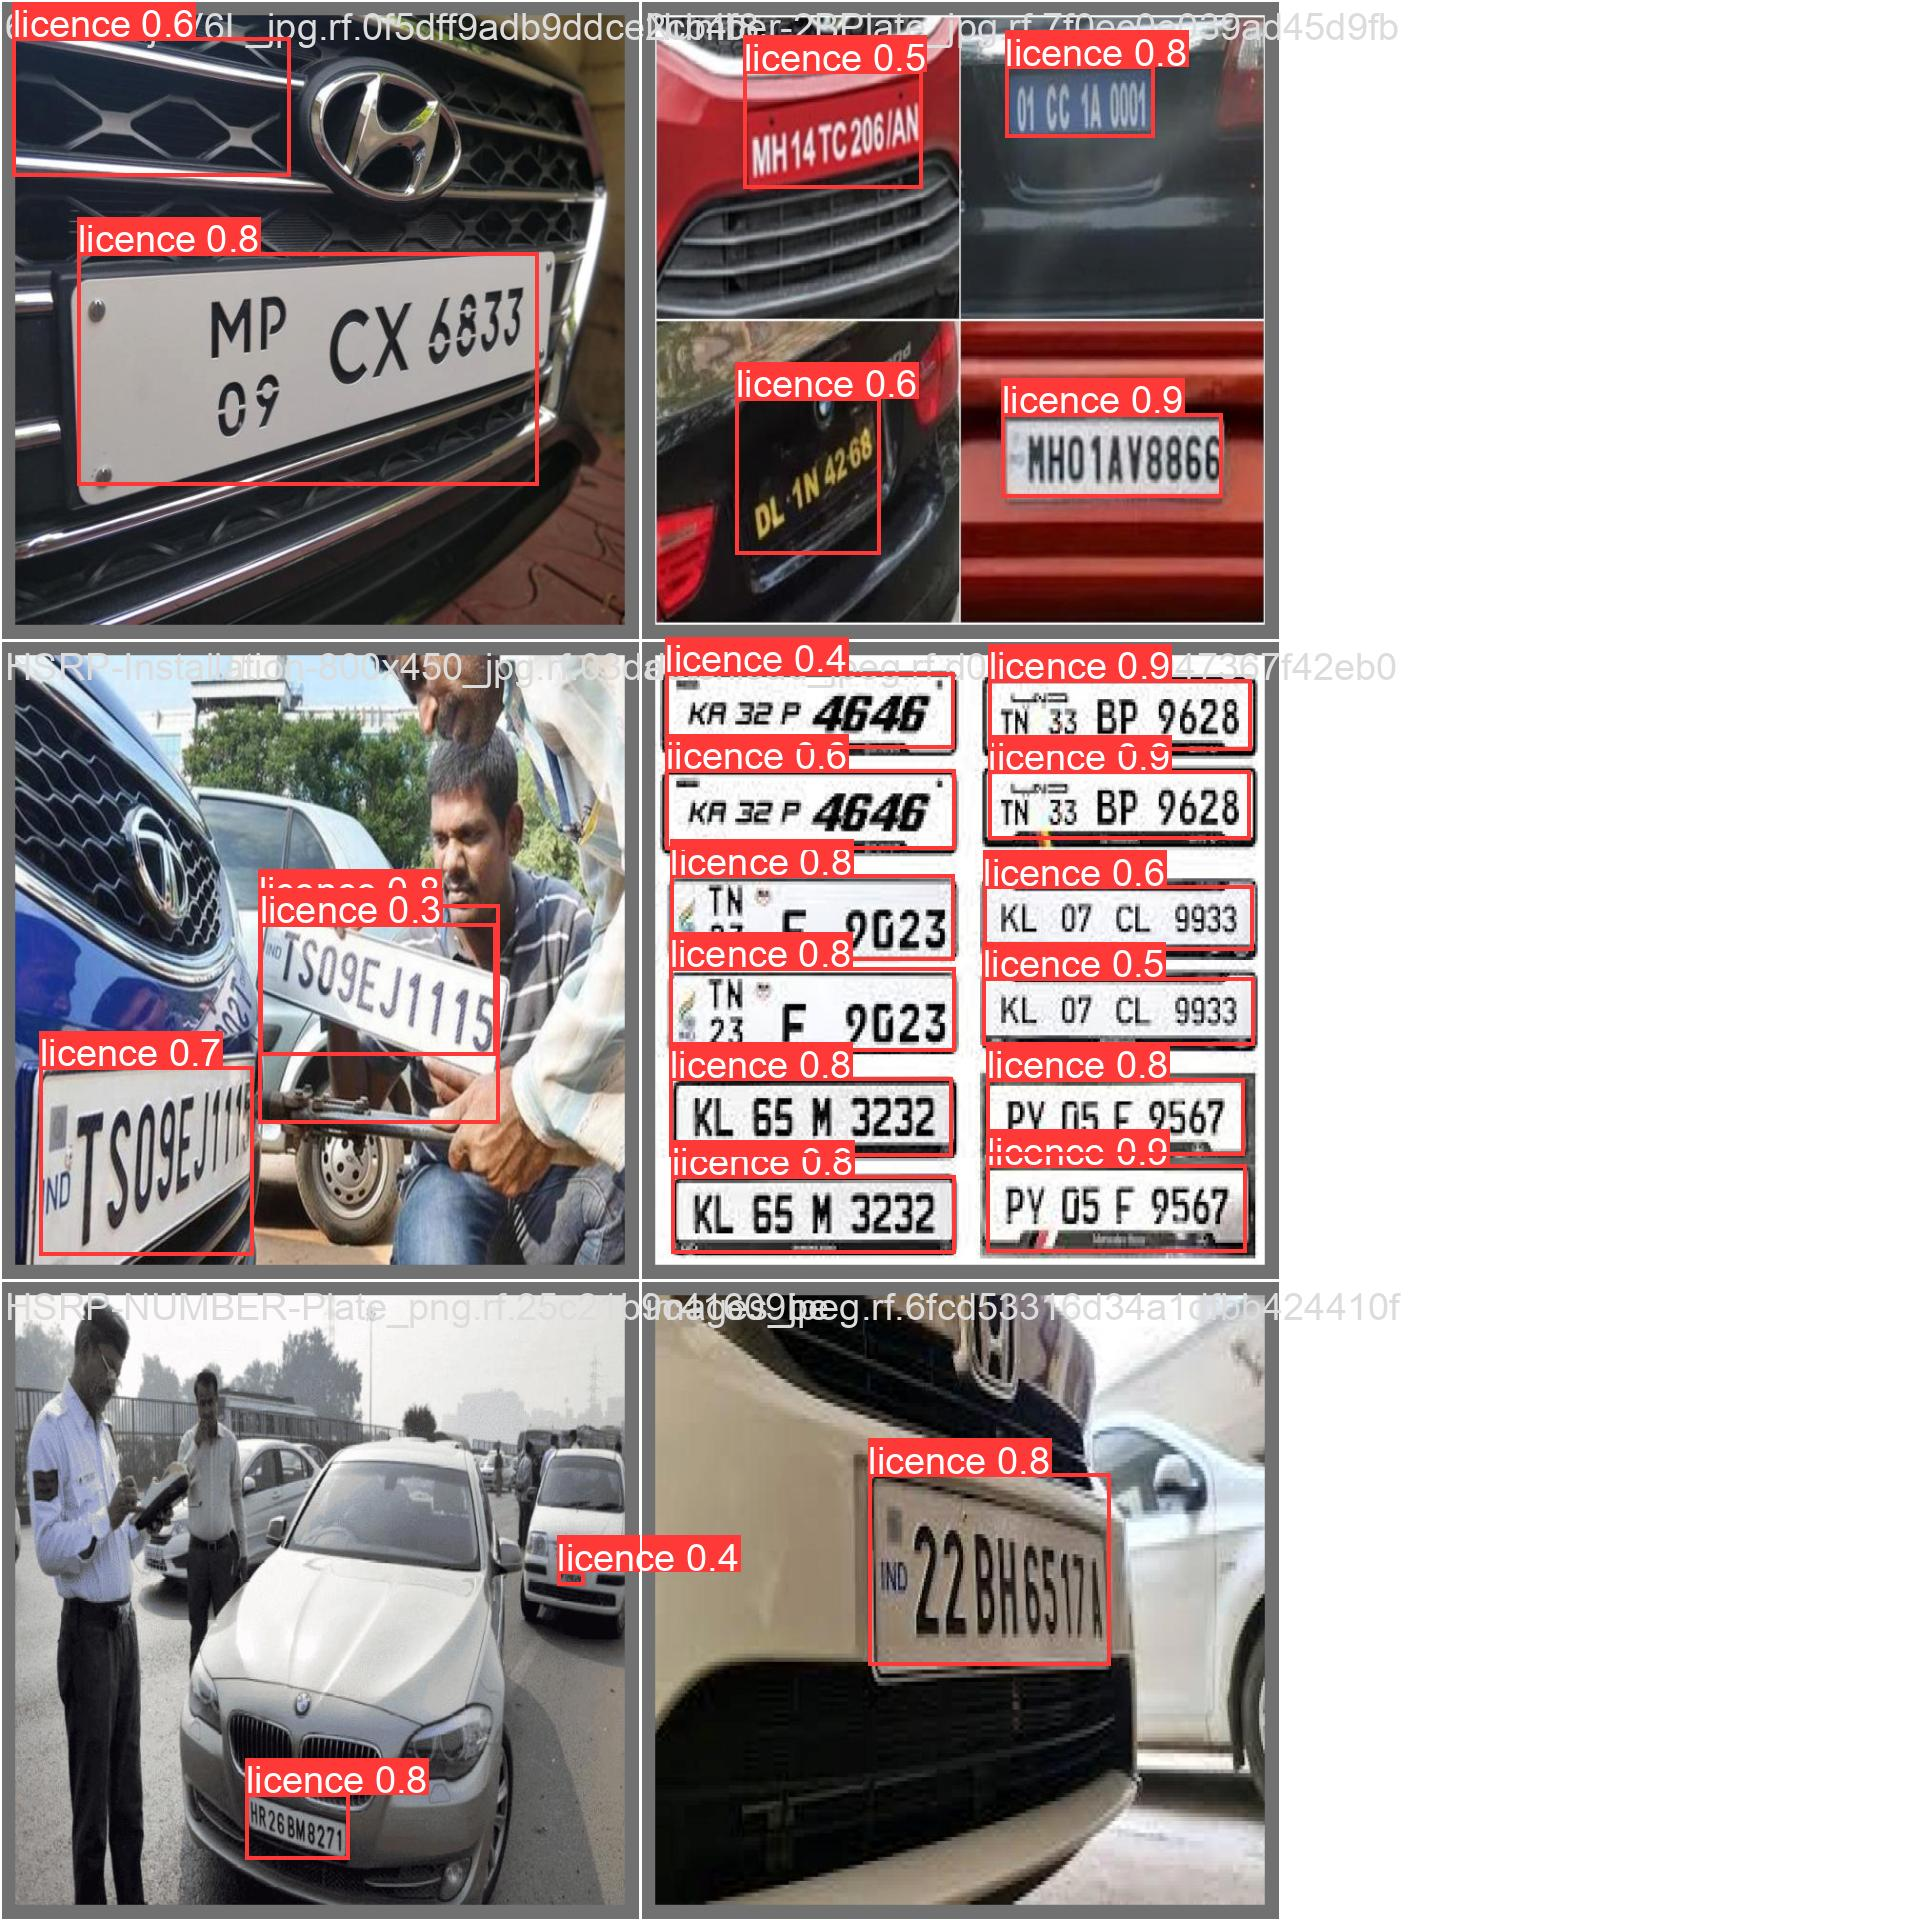

In [15]:
from IPython.display import Image

Image(filename=f"{HOME}/yolov9/runs/train/exp2/val_batch0_pred.jpg", width=1000)

## Validate Custom Model

In [16]:
%cd {HOME}/yolov9

!python val.py \
--img 640 --batch 32 --conf 0.001 --iou 0.7 --device 0 \
--data {dataset.location}/data.yaml \
--weights {HOME}/yolov9/runs/train/exp2/weights/best.pt

/content/yolov9
val: data=/content/yolov9/ANPR2-8/data.yaml, weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.7, max_det=300, task=val, device=0, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False, min_items=0
YOLOv5 🚀 1e33dbb Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions 

## Inference with Custom Model

In [17]:
!python detect.py \
--img 1280 --conf 0.1 --device 0 \
--weights {HOME}/yolov9/runs/train/exp2/weights/best.pt \
--source {dataset.location}/test/images

detect: weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], source=/content/yolov9/ANPR2-8/test/images, data=data/coco128.yaml, imgsz=[1280, 1280], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, t

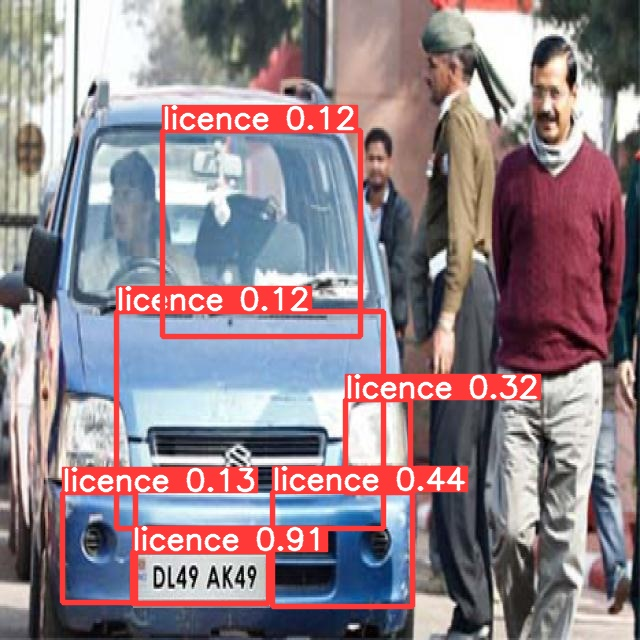

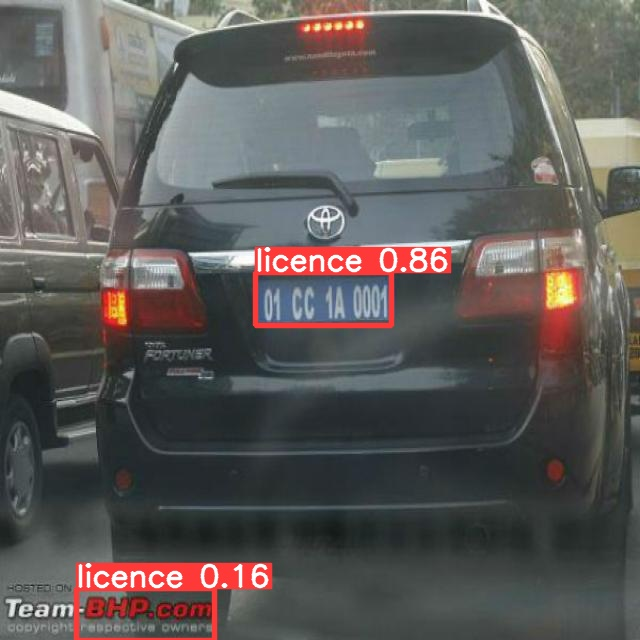

In [18]:
import glob

from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/yolov9/runs/detect/exp/*.jpg')[:2]:
      display(Image(filename=image_path, width=600))

In [19]:
# video

!python detect.py --conf 0.1 --device 0 --weights {HOME}/yolov9/runs/train/exp2/weights/best.pt --source car.mp4


detect: weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], source=car.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_

# Yolo v9 + easyOCR

In [20]:
!pip install easyocr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 26.0 MB/s eta 0:00:00


In [21]:
# video

!python anpr.py --conf 0.1 --device 0 --weights {HOME}/yolov9/runs/train/exp2/weights/best.pt --source car.mp4


Progress: |██████████████████████████████████████████████████| 100.0% CompleteDownloading recognition model, please wait. This may take several minutes depending upon your network connection.
Progress: |██████████████████████████████████████████████████| 100.0% Completeanpr: weights=['/content/yolov9/runs/train/exp2/weights/best.pt'], source=car.mp4, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 1e33dbb Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

/content/yolov9/models/experimental.py:75: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle mod

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cp -r /content/yolov9 /content/drive/MyDrive/yolov9_backup


In [ ]:
from google.colab import drive
drive.flush_and_unmount()


In [ ]:
!zip -r /content/project.zip /content
from google.colab import files
files.download("/content/project.zip")


  adding: content/ (stored 0%)
  adding: content/.config/ (stored 0%)
  adding: content/.config/default_configs.db (deflated 98%)
  adding: content/.config/config_sentinel (stored 0%)
  adding: content/.config/gce (stored 0%)
  adding: content/.config/.last_opt_in_prompt.yaml (stored 0%)
  adding: content/.config/configurations/ (stored 0%)
  adding: content/.config/configurations/config_default (deflated 15%)
  adding: content/.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: content/.config/logs/ (stored 0%)
  adding: content/.config/logs/2025.02.21/ (stored 0%)
  adding: content/.config/logs/2025.02.21/14.20.53.860402.log (deflated 58%)
  adding: content/.config/logs/2025.02.21/14.20.52.640451.log (deflated 87%)
  adding: content/.config/logs/2025.02.21/14.20.44.494684.log (deflated 58%)
  adding: content/.config/logs/2025.02.21/14.20.22.790589.log (deflated 93%)
  adding: content/.config/logs/2025.02.21/14.21.02.502663.log (deflated 58%

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>